## Supplement 4: Classification

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import mode
import matplotlib.pyplot as plt

### 4.2 Programming Task: K-Nearest Neighbor
The datasets in files __train-knn.csv__ and __test-knn.csv__ contain samples from a synthetic dataset for training a K-Nearest Neighbor classifier. The dataset consists of 7 columns: the first six columns, denoted as x1, x2, ..., x6 represent the input features for each data sample, and the last column represents the class label given by 0 or 1. There are 200 samples in the __train-knn.csv__ and 100 samples in the __test-knn.csv__.

i\. Implement the K-Nearest Neighbor classification algorithm using NumPy and SciPy.



In [2]:
train_set = pd.read_csv('train-knn.csv').to_numpy()
test_set = pd.read_csv('test-knn.csv').to_numpy()

def knn_predict(train_X, train_Y, test_X, k):

    # Calculate the distance
    distance_matrix = cdist(train_X, test_X)

    # Find the indices of the nearest neighbors
    neighbor_indices = distance_matrix.argsort(axis=0)[:k]

    # Find classes of nearest neighbors
    neighbor_classes = train_Y[neighbor_indices]

    # Find most frequent class among neighbors
    frequent_class,_ = mode(neighbor_classes, axis=0)

    # Argument -1 in reshape() simply means that it is an unknown dimension, and we want numpy to figure it out.
    return frequent_class.reshape(-1,)

    # Alternative to find most frequent class among neighbors
    # y_pred = []
    # for i in range(train_Y[neighbor_indices].shape[1]):
    #     nearest_labels = list(train_Y[neighbor_indices][:,i])
    #     y_pred.append(max(set(nearest_labels), key=nearest_labels.count))
    # return np.array(y_pred)

def get_accuracy(predicted_labels, true_labels):
    correct_count = np.sum([predicted_labels==true_labels])
    total_samples = predicted_labels.shape[0]

    accuracy = correct_count / total_samples

    return accuracy

# Last column is class labels
train_X = train_set[:,:-1]
train_Y = train_set[:,-1]

test_X = test_set[:,:-1]
test_Y = test_set[:,-1]

# Using a subset of the original dataset
predicted_y = knn_predict(train_X[:8], train_Y[:8], test_X[:1], k=3)

In [3]:
# Trying different synthetic datasets

# from sklearn.datasets import make_classification

# n_samples = 1200
# test_samples = int(n_samples=0.33)

# X, Y = make_classification(n_samples=n_samples, n_features=6, n_informative=4, n_redundant=0, n_classes=2)
# dataset = np.hstack((X, Y.reshape(-1,1)))

# test_set = dataset[:test_samples]
# train_set = dataset[test_samples:]

ii\. Perform cross-validation (with 5 folds) on the train dataset __train-knn.csv__ to determine a suitable value of K.


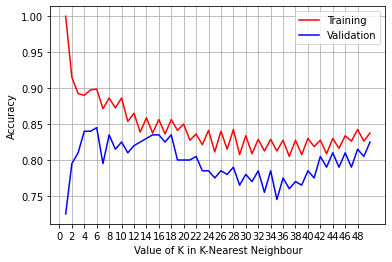

Best K from cross validation: 6


k  train_acc  val_acc
5    6    0.89875    0.845
3    4    0.89000    0.840
4    5    0.89750    0.840
7    8    0.88625    0.835
15  16    0.85625    0.835

In [4]:
n_fold = 5

train_size = train_set.shape[0]
indices = np.arange(train_size)
np.random.shuffle(indices)

# Split dataset
splits = np.array_split(indices, n_fold)

# List to store metrics for each value of k
exp = []

k_max = 50
for k in range(1, k_max+1):

    val_acc = np.zeros(n_fold)
    train_acc = np.zeros(n_fold)

    for fold in range(n_fold):
        val_indices = splits[fold]

        # Create mask that has 1 at val_set indices and 0 elsewhere
        mask = np.zeros(train_size, dtype=bool)
        mask[val_indices] = True

        # Get validation data by using mask
        cv_val_X = train_X[mask]
        cv_val_Y = train_Y[mask]

        # Get training data by inverting the mask
        cv_train_X = train_X[np.invert(mask)]
        cv_train_Y = train_Y[np.invert(mask)]

        # Train accuracy
        predicted_labels_train = knn_predict(cv_train_X, cv_train_Y, cv_train_X, k)
        train_acc[fold] = get_accuracy(predicted_labels_train, cv_train_Y)

        # Validation accuracy
        predicted_labels_val = knn_predict(cv_train_X, cv_train_Y, cv_val_X, k)
        val_acc[fold] = get_accuracy(predicted_labels_val, cv_val_Y)

    exp.append([k, train_acc.mean(), val_acc.mean()])

exp = pd.DataFrame(exp, columns=['k', 'train_acc', 'val_acc'])

plt.plot(exp['k'], exp['train_acc'], 'r', label='Training')
plt.plot(exp['k'], exp['val_acc'], 'b', label='Validation')
plt.xlabel('Value of K in K-Nearest Neighbour')
plt.xticks(np.arange(0, k_max, step=2))
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

exp.sort_values(by=['val_acc'], ascending=False, inplace=True)

best_k = int(exp.iloc[0]['k'])
print('Best K from cross validation:', best_k)

exp.head()

iii\. Using the optimal value of k from the cross-validation, obtain the accuracy of your model on the test dataset __test-knn.csv__.


In [5]:
predicted_labels = knn_predict(train_X, train_Y, test_X, best_k)
acc = get_accuracy(predicted_labels, test_Y)
print('Accuracy on test dataset:', int(acc*1000)/10, '%')

Accuracy on test dataset: 81.0 %


iv\. Compare your result with the KNeighborsClassifier model from the scikit-learn library.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold

model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(train_X, train_Y)

print('Accuracy of model from Scikit-learn library:', int(model.score(test_X, test_Y)*1000)/10, '%')

Accuracy of model from Scikit-learn library: 81.0 %


In [7]:
knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 50)}

# Use grid search to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=KFold(5, shuffle=True))

# Fit model to data
knn_gscv.fit(train_X, train_Y)

print(knn_gscv.best_params_['n_neighbors'])

8


v\. How do the bias and variance of each model vary as K increases?